# Image To Text Copy Paste

Ever wished to take a screen shot and be able to paste the text inside later? We're gonna do just that!

Let's start with the imports


## Boring Imports - Run this

In [ ]:
#hide
%%capture
!sudo apt install tesseract-ocr
!pip install opencv-python pytesseract imutils
!pip install -q -U fastai
!git clone https://github.com/afry-south/nlp-competence

In [ ]:
import cv2
import pytesseract
import imutils
from fastai import *
from fastai.vision.all import *
import numpy as np
from imutils.object_detection import non_max_suppression

root_path = Path("/content/nlp-competence/python/20201214 - #9 [Image To Text Copy Paste]")
path_east = root_path / "frozen_east_text_detection.pb"
path_images = root_path / "images"

class TODO(Exception):
    """Raised when the code needs to be implemented"""
    def __init__(self,  message):
        self.message = message
        super().__init__(self.message)

## **Discussion:** What do we need to do

- Problem
  - Understanding
  - Heuristics
- Data
  - Understanding
  - Format
  - Preparation
  - Transformations / Augmentations
- Model(s)
  - What exists?
  - What do we need?
- Application
  - GUI
  - Keyboard Integration?
  - Simple tool
  - ((Has to be done locally in Python; an implementation do exist))

## Baseline 1.0 - Recognizing Text

Let's start with a baseline which is simple to implement yet work.

### Introducing Tesseract
Tesseract is an [_optical character recognition_](https://en.wikipedia.org/wiki/Optical_character_recognition) (OCR) which is Open Source (Apache License), first developed by Hewlett-Packard (HP) during the 80s and started out as proprietary software. In 2005 it became Open Source and Google have been backing it ever since.

In 2006 Tesseract was considered the most accuracte OCR system in the world, which is pretty impressive!

### What is OCR?

A lot of us (Swedes) knows OCR from the OCR-number on our bills.  
![ocr-bill](https://medier.talentum.com/ponIltIpIv-1457371608/media/kg4ryn-OCD-nummer1114.jpg/alternates/FREE_400/OCD-nummer1114.jpg)

In its essence it is about recognizing characters and being able to map them into the correct character.  
<img src="https://s3.amazonaws.com/element-ai-website-bucket/_992x587_crop_center-center_82_line/OCR-Handwritten-documents@2x.jpg" alt="ocr" width="400"/>

So how do we do this?

We need to

1. Find Text
2. Classify Text
3. Return Text

### Getting and visualizing images
We need to grab the images from the file-system and be able to view them. Let's start with that.

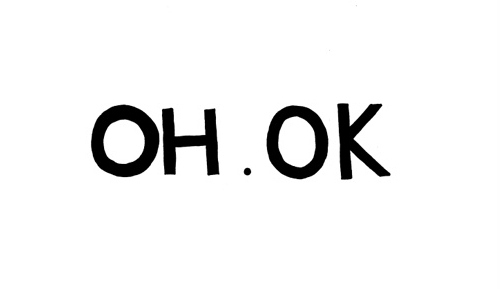

In [ ]:
imgs = get_image_files(path_images)

def create_img(image_path):
    raise TODO("Take PILImage and create an image out of imgs[3]")

img = create_img(imgs[3]); img

Now we need to test out our baseline, `Tesseract`. `Tesseract` is a model of high performance to do OCR. It's not perfect but certainly good.

We need to understand how to configure `Tesseract` to make the most use out of it.

**The Tesseract Config**  
`l` for _language_ (default=eng), e.g. `-l 'eng+fra'`

`oem` for _OCR Engine Mode_. (0: Legacy, 1: LSTM, 2: Legacy + LSTM, 3: What's available)

`psm` for _Page Segmentation Mode_
- 0 = Orientation and script detection (OSD) only.
- 1 = Automatic page segmentation with OSD.
- 2 = Automatic page segmentation, but no OSD, or OCR.
- 3 = **Fully automatic page segmentation, but no OSD. (Default)**
- 4 = Assume a single column of text of variable sizes.
- 5 = Assume a single uniform block of vertically aligned text.
- **6 = Assume a single uniform block of text.**
- **7 = Treat the image as a single text line.**
- 8 = Treat the image as a single word.
- 9 = Treat the image as a single word in a circle.
- 10 = Treat the image as a single character.



In [ ]:
custom_config = r'--oem 3 --psm 3'
raise TODO("Call pytesseracts image_to_string using the same image (img) you visualized and the custom config")

'OH .OK\n\x0c'

At least the "Oh .Ok" seems to work decently enough... But this is not great. It works, no more, no less!

Baseline 1.0 done!  

## Baseline 2.0 - Find Text to help Tesseract
I hope, and guess, that this was part of the discussion previously. As long as we keep working with _baselines_ we'll do it a simple (and not very custom) way. Let's figure out how we can use `opencv` to recognize text-blocks.

What does this mean?  

- [ ] Parse Image (recognize height, width)
- [ ] Transform Image (normalize)
- [ ] Find the smaller areas where text exists
- [ ] OCR on top of text

All of this is possible through a combination of `opencv` & `tesseract`, which makes perfect sense for a baseline!  
We'll use _Efficient and Accurate Scene Text Detector_ (EAST) which is Open Source, found [here](https://github.com/argman/EAST) and the paper [here](https://arxiv.org/abs/1704.03155v2).  
The model achieves 80.83 F1-score on ICDAR 2015 Incidental Scene Text Detection.

**Performance:** Speed on 720p (resolution of 1280x720) images:   
- Graphic card: GTX 1080 Ti
- Network fprop: ~50 ms
- NMS (C++): ~6ms
- Overall: ~16 fps

Let's start by putting our layers into a list.

In [ ]:
layers = layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

# Note Path() does not work, but needs to stringify!
def load_net(path=path_east):
    raise TODO("Make use of cv2 neural net loader (`cv2.dnn.readNet`) and given path previously")
    return net

net = load_net()

### Decoder & Predict
We don't need to learn how the decoder works. Essentially it's glue to transform geometry into bounding boxes and filter out the ones that have > `min_confidence` score.

Two new methods `pil_to_cv2` & `cv2_to_image_blog` is introduced which does what they say.

Most interesting method `predict` with the signature

`def predict(net, img, config=("-l eng --oem 1 --psm 7"), layers=layerNames, min_confidence=0.5, padding=0.0)`

If you like we can go through what it does. But essentially we choose a config for `tesseract` and then we predict through `tesseract` for each Bounding Box that `EAST` finds with `min_confidence`.

If you wanna get to your own implementation, just run this block and move forward!

In [ ]:
def decode_predictions(scores, geometry, min_confidence):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# loop over the number of columns
		for x in range(0, numCols):
			uncertain_prediction = scoresData[x] < min_confidence
			if uncertain_prediction: continue

			(offsetX, offsetY) = (x * 4.0, y * 4.0)

			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			(cos, sin) = (np.cos(angle), np.sin(angle))

			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	return (rects, confidences)

In [ ]:
def pil_to_cv2(pil_image):
    return cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

def cv2_img_to_blob(cv2_img):
    return cv2.dnn.blobFromImage(cv2_img, 1.0, cv2_img.shape[:2],
        (123.68, 116.78, 103.94), swapRB=True, crop=False)

In [ ]:
def predict(net, img, config=("-l eng --oem 1 --psm 7"), layers=layerNames, min_confidence=0.5, padding=0.0):
    (newW, newH) = (320, 320)
    orig_cv2 = pil_to_cv2(img)
    
    (rW, rH) = (img.width / float(newW), img.height / float(newH))
    cv2_img = pil_to_cv2(img.resize((newW, newH)))
    resized_cv2_img = cv2_img_to_blob(cv2_img)
    net.setInput(resized_cv2_img)

    (scores, geometry) = net.forward(layers)
    (rects, confidences) = decode_predictions(scores, geometry, min_confidence)
    bboxes = non_max_suppression(np.array(rects), probs=confidences) # [(startX, startY, endX, endY), ...]
    
    results = []
    for (startX, startY, endX, endY) in bboxes:
        # Scale BBox
        (startX, startY, endX, endY) = (int(startX * rW), int(startY * rH), int(endX * rW), int(endY * rH))

        # Currently padding=0
        (dX, dY) = (int((endX - startX) * padding), int((endY - startY) * padding))

        # apply padding to each side of the bounding box, respectively
        (startX, startY) = (max(0, startX - dX), max(0, startY - dY))
        (endX, endY) = (min(img.width, endX + (dX * 2)), min(img.height, endY + (dY * 2)))

        # extract the actual padded ROI
        roi = orig_cv2[startY:endY, startX:endX]

        # Tesseract for OCR
        text = pytesseract.image_to_string(Image.fromarray(roi), config=config)
        # add the bounding box coordinates and OCR'd text to the list
        results.append(((startX, startY, endX, endY), text))

    # sort the results bounding box coordinates from top to bottom
    results = sorted(results, key=lambda r:r[0][1])
    
    return results

### Testing our baseline

Let's test our baseline some! 
There's one thing that we should do but I was too lazy to glue together; add baseline scoring. 

The baseline is mainly added to have a end-2-end glued product that you can use already today! :) 

In [ ]:
pred = predict(net, img); pred

NameError: ignored

In [ ]:
img_2 = create_img(imgs[2]);

[((0, 214, 600, 273), '® MIDDLEBOROUGH\n\x0c')]

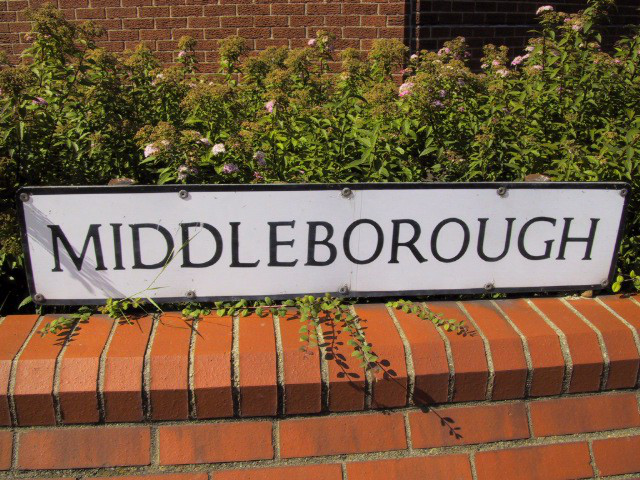

In [ ]:
pred = predict(net, img_2); pred

## Establing a Object Detection Model

We have a few ways to move forward here. First we need to go back to our discussion and go through what we said about data and more.

Then we need to select how we want to implement / train our model

I've attached a few ways to train / implement this.

1. Develop our own from scratch
2. RetinaNet (via Fast.AI)
3. YOLO (v3) ([via YOLOs own trainer](https://github.com/ultralytics/yolov3/wiki/Train-Custom-Data) or [via Fast.AI](https://github.com/Mersive-Technologies/yolov3/blob/master/fastai.ipynb))
5. DETR ([from-scratch-implementation](https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb) or [fine-tuning](https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb#scrollTo=07IsWxj2YTEY))
  - This is a completely new way of doing this which greatly simplifies the model. See [blog](https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/).
6. EfficientDet ([via IceVision](https://airctic.com/quickstart/) which interacts smoothly with Fast.AI && PytorchLightning).
7. Detectron2 ([facebooks own tool](https://github.com/facebookresearch/detectron2), supports most architectures)

**DETR Comparison**:


<img src="https://scontent-arn2-1.xx.fbcdn.net/v/t39.2365-6/98328450_244310383568962_7955889666970877952_n.jpg?_nc_cat=106&ccb=2&_nc_sid=ad8a9d&_nc_ohc=MrU5up-QIh4AX_Tct9c&_nc_ht=scontent-arn2-1.xx&oh=48d7ecc584e88d018c88f602343b9a13&oe=5FFDE68C" alt="drawing" width="500"/>



### RetinaNet (Fast.AI)

This is a baseline implementation of RetinaNet on top of PASCAL dataset from 2007. We can take this model and fine-tune it for our task.

First we need to download our data and understand how it is organized.

In [ ]:
path = untar_data(URLs.PASCAL_2007)

In [ ]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/valid.json')]

To get our images and annotations fast.ai provides a handy tool, `get_annotations`.

In [ ]:
imgs, lbl_bbox = get_annotations(path/'train.json')

Let's take a look at what we got here. Remember fast.ai loads images in the dataloaders for you, so only filename is relevant.

In [ ]:
imgs[0]

'000012.jpg'

In [ ]:
lbl_bbox[0]

([[155, 96, 351, 270]], ['car'])

In [ ]:
img2bbox = dict(zip(imgs, lbl_bbox))

In [ ]:
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'000012.jpg': ([[155, 96, 351, 270]], ['car'])}

In [ ]:
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]

In [ ]:
item_tfms = [Resize(128, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [ ]:
def get_train_imgs(noop): return imgs

Now that we got the tools required. Let's create a DataBlock and figure out why we do what we do.

In [ ]:
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs,
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

And load our training data, plus visualizing it.

In [ ]:
dls = pascal.dataloaders(path/'train')

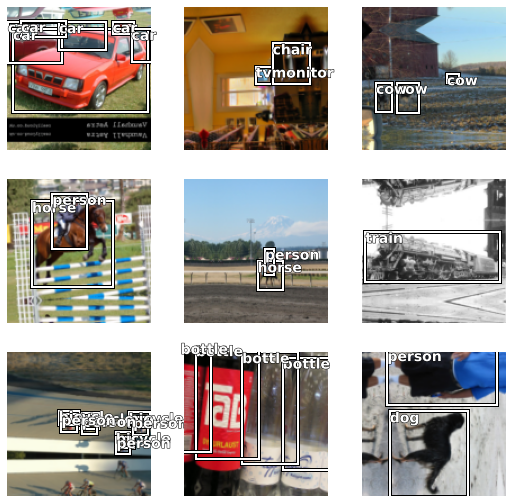

In [ ]:
dls.c = 20 # knowledge about data
dls.show_batch()

In [ ]:
!git clone https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0.git
%cd "Practical-Deep-Learning-for-Coders-2.0/Computer Vision"

Cloning into 'Practical-Deep-Learning-for-Coders-2.0'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1292 (delta 18), reused 27 (delta 6), pack-reused 1227
Receiving objects: 100% (1292/1292), 86.33 MiB | 34.82 MiB/s, done.
Resolving deltas: 100% (805/805), done.
/content/Practical-Deep-Learning-for-Coders-2.0/Computer Vision/Practical-Deep-Learning-for-Coders-2.0/Computer Vision


In [ ]:
from imports import *

In [ ]:
encoder = create_body(resnet34, pretrained=True)

In [ ]:
get_c(dls)

20

In [ ]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

In [ ]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=124, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

In [ ]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

LOSS

In [ ]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

In [ ]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

In [ ]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [ ]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [ ]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

In [ ]:
https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5
https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb#scrollTo=GJhCp8y0-b-H 

SyntaxError: ignored

### DETR Fine-Tune

#### Some Imports
Just execute this block containing imports, CLASSES and some small util-functions.

In [ ]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [ ]:
# COCO classes
CLASSES = ['N/A', 'text']
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

#### Loading the model via `torch.hub`
Let's load our model up and try to predict something! 
We'll move on to fine-tuning this later.

In [ ]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


In [ ]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [ ]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

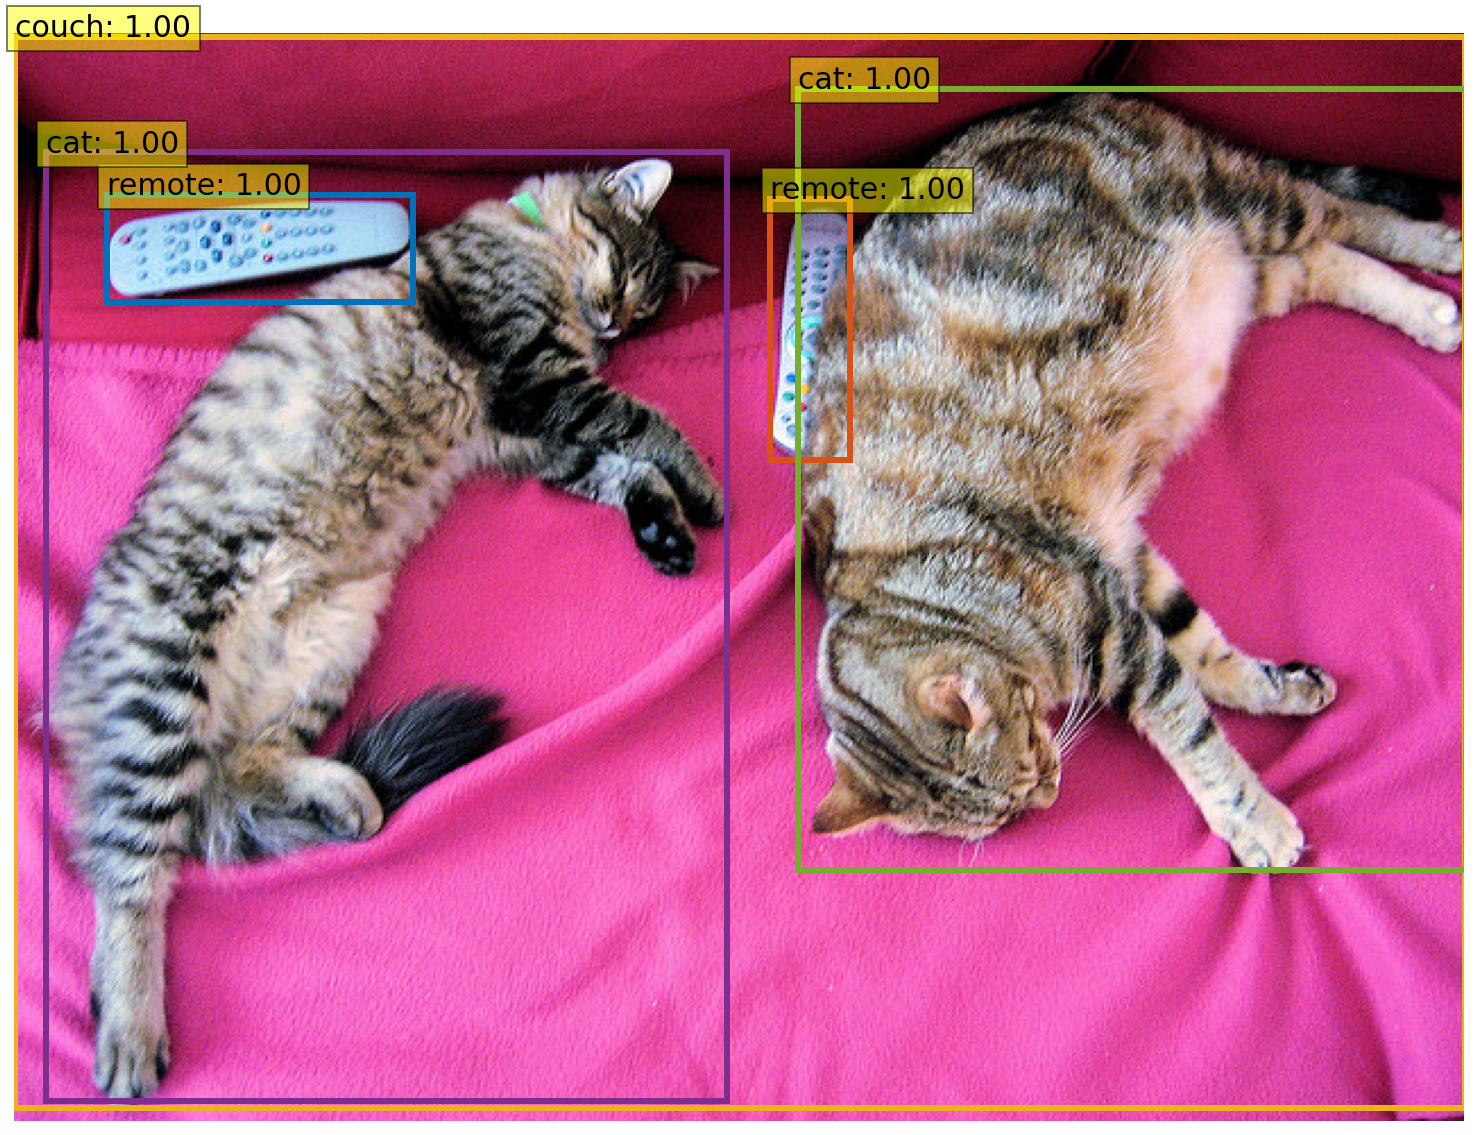

In [ ]:
plot_results(im, probas[keep], bboxes_scaled)

In [ ]:
model.class_embed,model.transformer,model.backbone

(Linear(in_features=256, out_features=92, bias=True), Transformer(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0): TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
         )
         (linear1): Linear(in_features=256, out_features=2048, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=2048, out_features=256, bias=True)
         (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
       (1): TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
         )
         (linear1): Linear(in_features=256, out_features=2048, bias=T

## Annotating data
I found a pretty good tool in [_MakeSense.AI_](https://www.makesense.ai/).

If you want your own data, let's roll with that solution!

## Creating the Desktop App
We need to glue this together into a nice desktop app!

### Ugly code to copy-paste
We're using Qt to draw things on the desktop.

In [ ]:
import sys
from datetime import datetime

import pyperclip
import pytesseract
from PIL import Image
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtCore import Qt

try:
    from pynotifier import Notification
except ImportError:
    pass

class Snipper(QtWidgets.QWidget):
    def __init__(self, parent=None, flags=Qt.WindowFlags()):
        super().__init__(parent=parent, flags=flags)

        self.setWindowTitle("ScreenGrab")
        self.setWindowFlags(Qt.FramelessWindowHint | Qt.WindowStaysOnTopHint | Qt.Dialog)
        self.setWindowState(self.windowState() | Qt.WindowFullScreen)

        self.screen = QtWidgets.QApplication.screenAt(QtGui.QCursor.pos()).grabWindow(0)
        palette = QtGui.QPalette()
        palette.setBrush(self.backgroundRole(), QtGui.QBrush(self.screen))
        self.setPalette(palette)

        QtWidgets.QApplication.setOverrideCursor(QtGui.QCursor(QtCore.Qt.CrossCursor))

        self.start, self.end = QtCore.QPoint(), QtCore.QPoint()

    def keyPressEvent(self, event):
        if event.key() == Qt.Key_Escape: QtWidgets.QApplication.quit()

        return super().keyPressEvent(event)

    def paintEvent(self, event):
        painter = QtGui.QPainter(self)
        painter.setPen(Qt.NoPen)
        painter.setBrush(QtGui.QColor(0, 0, 0, 100))
        painter.drawRect(0, 0, self.width(), self.height())

        if self.start == self.end:
            return super().paintEvent(event)

        painter.setPen(QtGui.QPen(QtGui.QColor(255, 255, 255), 3))
        painter.setBrush(painter.background())
        painter.drawRect(QtCore.QRect(self.start, self.end))
        return super().paintEvent(event)

    def mousePressEvent(self, event):
        self.start = self.end = event.pos()
        self.update()
        return super().mousePressEvent(event)

    def mouseMoveEvent(self, event):
        self.end = event.pos()
        self.update()
        return super().mousePressEvent(event)

    def mouseReleaseEvent(self, event):
        if self.start == self.end:
            return super().mouseReleaseEvent(event)

        self.hide()
        QtWidgets.QApplication.processEvents()
        shot = self.screen.copy(QtCore.QRect(self.start, self.end))
        process_image(shot)
        QtWidgets.QApplication.quit()

def process_image(img):
    buffer = QtCore.QBuffer()
    buffer.open(QtCore.QBuffer.ReadWrite)
    img.save(buffer, "PNG")
    # pil_img = Image.open(io.BytesIO(buffer.data()))
    buff = io.BytesIO(buffer.data())
    from advanced_ocr import process_image
    process_image(buff, path_east="frozen_east_text_detection.pb")

    try:
        result = pytesseract.image_to_string(pil_img, timeout=2, lang=(
            sys.argv[1] if len(sys.argv) > 1 else None))
    except RuntimeError as error:
        # print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} [ERROR]: An error occurred when trying to process the image: {error}")
        notify(f"An error occurred when trying to process the image: {error}")
        return

    if result:
        pyperclip.copy(result)
        # print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} [INFO]: Copied '{result}' to the clipboard")
        notify(f'Copied "{result}" to the clipboard')
    else:
        # print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} [INFO]: Unable to read text. No copy.")
        notify(f"Unable to read text from image, did not copy")

def notify(msg):
    try:
        Notification(title="ScreenGrab", description=msg).send()
    except (SystemError, NameError):
        trayicon = QtWidgets.QSystemTrayIcon(
            QtGui.QIcon(
                QtGui.QPixmap.fromImage(QtGui.QImage(
                    1, 1, QtGui.QImage.Format_Mono))
            )
        )
        trayicon.show()
        trayicon.showMessage("ScreenGrab", msg, QtWidgets.QSystemTrayIcon.NoIcon)
        trayicon.hide()

if __name__ == "__main__":
    try:
        pytesseract.get_tesseract_version()
    except EnvironmentError:
        notify(
            "Tesseract is either not installed or cannot be reached.\n"
            "Have you installed it and added the install directory to your system path?"
        )
        print(
            "ERROR: Tesseract is either not installed or cannot be reached.\n"
            "Have you installed it and added the install directory to your system path?"
        )
        sys.exit()

    QtCore.QCoreApplication.setAttribute(Qt.AA_DisableHighDpiScaling)
    app = QtWidgets.QApplication(sys.argv)
    window = QtWidgets.QMainWindow()
    snipper = Snipper(window)
    snipper.show()
    sys.exit(app.exec_())